# LTX - Learn To Explain

In [12]:
import os
import sys
if os.getcwd().endswith('notebooks'):
    os.chdir('../')
    print(f'Changed working directory to {os.getcwd()}')
    
from src.dataset.fer_dataset import FERDataset
from src.explained.models import FERClassifier
from src.paths import TRAIN, TEST, CHECKPOINTS, LOGS


from torch.utils.data import DataLoader, Dataset
import torch
from torchvision import models
from torcheval.metrics import MulticlassAccuracy

from torchvision.transforms.v2 import(
    CenterCrop,  
    Compose,  
    Normalize,  
    RandomRotation,  
    RandomResizedCrop,  
    RandomHorizontalFlip, 
    RandomAdjustSharpness,  
    Resize,  
    ToImage
)

from lightning.pytorch import LightningModule, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

from transformers import AutoModel, AutoImageProcessor, AutoModelForImageClassification


from functools import partial
from tqdm import tqdm

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## LTX Modules

In [13]:
class CNNExplainer(LightningModule):
    """
    Creating a visual explanation model for CNNs.
    """
    def __init__(self, cnn_model, activation_function: str = "sigmoid", img_size: int = 224):
        super().__init__()
        self.img_size = img_size
        self.activation_function = activation_function
        backbone_children = list(cnn_model.children())
        input_features = backbone_children[-1].in_features
        self.encoder = torch.nn.Sequential(*backbone_children[:-2])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=input_features, out_channels=1, kernel_size=1, stride=1
            ),
        )

    def forward(self, inputs):  # inputs.shape: [batch_size, 3, 224, 224]
        batch_size = inputs.shape[0]
        self.encoder.eval()
        enc_rep = self.encoder(inputs)
        mask = self.bottleneck(enc_rep)
        if self.activation_function == 'sigmoid':
            tokens_mask = torch.sigmoid(mask)

        interpolated_mask = torch.nn.functional.interpolate(
            tokens_mask,
            scale_factor=int(inputs.shape[-1] / mask.shape[-1]),
            mode="bilinear"
        )
        interpolated_mask = interpolated_mask.view(
            batch_size, 1, self.img_size, self.img_size
        )
        return interpolated_mask, tokens_mask  # [batch_size, 1, img_size, img_size] , [batch_size, 1, n_tokens]

In [14]:
class LTXLoss(torch.nn.Module):
    def __init__(self,
                 lambda_mask: float = 30.0,
                 lambda_inv: float = 0.0,
                 lambda_smooth: float = 0.0):
        super().__init__()
        self.lambda_mask = lambda_mask
        self.lambda_inv = lambda_inv
        self.lambda_smooth = lambda_smooth
        self.pred_loss_fn = torch.nn.CrossEntropyLoss()

        self.pred_loss = 0
        self.mask_loss = 0
        self.inv_loss = 0
        self.smooth_loss = 0

    def forward(self,
                logits_m: torch.Tensor,
                logits_inv: torch.Tensor,
                mask: torch.Tensor,
                target: torch.Tensor) -> torch.Tensor:
        
        # 1. Prediction loss
        self.pred_loss = self.pred_loss_fn(logits_m, target)

        # 2. Mask sparsity (L1)
        self.mask_loss = mask.abs().mean()

        # 3. Inversion: encourage misclassification (maximize entropy)
        # take negative pos loss (BCE)
        inv = -self.pred_loss_fn(logits_inv, target)

        # 4. Smoothness: TV via conv for compactness
        # WIP
        smooth = torch.tensor(0.0, device=mask.device)

        # 5. Weighted sum
        return (self.pred_loss
                + self.lambda_mask * self.mask_loss
                + self.lambda_inv * inv
                + self.lambda_smooth * smooth
                )

In [15]:
class LTX(LightningModule):
    """
    LightningModule that encapsulates:
    1. The frozen explained model (e.g. a pretrained CNN or ViT).
    2. The trainable explainer (CNNExplainer).
    3. The counterfactual LTX loss.
    Handles both pretraining (on a dataset) and can be re-used for per-instance finetuning.
    """
    num_classes = 7  # Number of classes in the FER dataset TODO: make it dynamic
    def __init__(
        self, 
        explained_model: torch.nn.Module,
        explainer = CNNExplainer,
        activation_function: str = "sigmoid",
        img_size: int = 224,
        img_mean: list = [0.5, 0.5, 0.5],
        img_std: list = [1,1, 1],
        lr: float = 2e-3,
        lambda_mask: float = 30.0,
        lambda_inv: float = 0.0,
        lambda_smooth: float = 0.0,
    ):
        super().__init__()
        # freeze the explained model
        self.explained = explained_model.eval()
        for p in self.explained.parameters():
            p.requires_grad = False

        # save hyperparameters
        self.save_hyperparameters(
            "activation_function",
            "img_size",
            "lr",
            "lambda_mask",
            "lambda_inv",
            "lambda_smooth",
        )

        self.explainer = explainer
        explainer.activation_function = activation_function
        
        self.img_mean = img_mean
        self.img_std = img_std

        self.loss_fn = LTXLoss(
            lambda_mask=lambda_mask,
            lambda_inv=lambda_inv,
            lambda_smooth=lambda_smooth,
        )

    def forward(self, x):
        # returns (upsampled_mask, raw_mask)
        return self.explainer(x)

    def _normalize_masked_image(self, xm):
        mean = torch.as_tensor(self.img_mean).to(self.device)
        std = torch.as_tensor(self.img_std).to(self.device)
        new_xm = xm.clone()
        new_xm.sub_(mean[None, :, None, None]).div_(std[None, :, None, None])
        return new_xm

    def log_metrics(self, logits_m, logits_inv, target, prefix: str = "train"):
        self.log(f"{prefix}/pred_loss", self.loss_fn.pred_loss, on_step=False, on_epoch=True)
        self.log(f"{prefix}/mask_loss", self.loss_fn.mask_loss, on_step=False, on_epoch=True)
        # self.log(f"{prefix}/inv_loss", self.loss_fn.inv_loss, on_step=False, on_epoch=True)
        # self.log(f"{prefix}/smooth_loss", self.loss_fn.smooth_loss, on_step=False, on_epoch=True)

        # explained accuracy
        acc = MulticlassAccuracy(num_classes=self.num_classes)
        acc.update(logits_m, target)
        self.log(f"{prefix}/pred_accuracy", acc.compute(), on_step=False, on_epoch=True)
        acc.update(logits_inv, target)
        self.log(f"{prefix}/inv_accuracy", acc.compute(), on_step=False, on_epoch=True)

    def _eval(self,x,y,mode):
        # 1. get mask
        up_mask, raw_mask = self.explainer(x)

        # 2. form masked and inverted inputs
        up_mask = torch.sigmoid(up_mask)  # ensure mask is in [0,1]
        xm = x * up_mask  # upsampled mask
        x_inv = x * (1 - up_mask)

        # Normalize masked images for explained model
        if isinstance(self.explainer, CNNExplainer):
            # For cnn - normalize mask
            # TODO: make subclass for CNN and ViT
            xm = self._normalize_masked_image(xm)
            x_inv = self._normalize_masked_image(x_inv)

        # 3. feed through explained model
        logits_m = self.explained(xm)
        logits_inv = self.explained(x_inv)

        # 4. compute LTX loss
        loss = self.loss_fn(logits_m, logits_inv, raw_mask, y)
        
        self.log(f"{mode}/loss", loss, prog_bar=True)
        self.log_metrics(logits_m, logits_inv, y, prefix=mode)
        return loss

    def training_step(self, batch, batch_idx):
        x, y = batch  # x: [B,3,H,W], y: [B]
        loss = self._eval(x, y, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        loss = self._eval(x, y, mode="val")
        return loss

    def configure_optimizers(self):
        # add a scheduler if needed
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

## Pre Training 

### Setup

#### Models

In [16]:
# TODO: put in config or some other place
img_size = 224
batch_size = 32
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18", use_fast=True)

In [17]:
EXPLAINED_TYPE = 'cnn'  # or 'vit' for ViT-based explainers

explain_backbone = models.resnet18(weights='IMAGENET1K_V1')
checkpoints_path = os.path.join(CHECKPOINTS,EXPLAINED_TYPE)
explained_model = FERClassifier.load_from_checkpoint(
    checkpoint_path=os.path.join(checkpoints_path, "best-checkpoint.ckpt"), 
    backbone=explain_backbone, 
    backbone_type=EXPLAINED_TYPE
)

explainer = CNNExplainer(
    cnn_model=explained_model.backbone,
    activation_function='sigmoid',
    img_size=img_size
)

ltx = LTX(
    explained_model=explained_model,
    explainer=explainer,
    activation_function='sigmoid',
    img_size=img_size,
    lr=2e-3,
    lambda_inv=0,
    lambda_mask=50
)


#### Data

In [7]:
train_transforms = Compose(
    [
        Resize((img_size, img_size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),   
        RandomHorizontalFlip(0.5),
    ]
)

test_transforms = Compose(
    [
        Resize((img_size, img_size))
    ]
)

In [8]:
train = FERDataset(root_dir='data/fer-2013/train', transform=train_transforms)
test = FERDataset(root_dir='data/fer-2013/test', transform=test_transforms)

In [9]:
def collate_fn(batch, processor):
    img = [item['pixel_values'] for item in batch]
    labels = [item['label'] for item in batch]
    processed_img = processor(img)
    
    img_tesnor = torch.stack(processed_img['pixel_values'])
    label_tensor = torch.tensor(labels, dtype=torch.long)
    return img_tesnor, label_tensor

train_loader = DataLoader(
    train, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=partial(collate_fn, processor=processor)
)
test_loader = DataLoader(
    test, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=partial(collate_fn, processor=processor)
)

## Training

In [10]:
checkpoints_path = os.path.join(CHECKPOINTS, 'LTX' , EXPLAINED_TYPE)
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoints_path,
    filename='best-checkpoint',
    monitor='val/loss',
    mode='min',
    save_top_k=1,
    enable_version_counter=False
)

logs_path = os.path.join(LOGS, 'LTX', EXPLAINED_TYPE)

early_stopping_callback = EarlyStopping(
    monitor='val/loss',
    patience=5,  # Stop training if no improvement for 3 epochs
    mode='min',  # We want to minimize the validation loss
    verbose=False,
    check_finite=True
)

logger = TensorBoardLogger(
    logs_path
)

trainer = Trainer(
    max_epochs=10,
    accelerator='gpu',
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(
    model=ltx,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader
    )

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
e:\tools\miniconda3\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory E:\projects\explain-for-action\models\checkpoints\LTX\cnn exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | explained | FERClassifier | 11.7 M | eval 
1 | explainer | CNNExplainer  | 11.2 M | train
2 | loss_fn   | LTXLoss       | 0      | train
----------------------------------------------------
513       Trainable params
11.7 M    Non-trainable params
11.7 M    Total params
46.774    Total esti

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\tools\miniconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
e:\tools\miniconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [16]:
class SingleTensorData(Dataset):
    def __init__(
        self,
        image = torch.tensor,
        target = torch.tensor        
    ):
        self.image = image
        self.target = target

    def __getitem__(self, index):
        return self.image, self.target

    def __len__(self):
        return 1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 3019.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9602615].


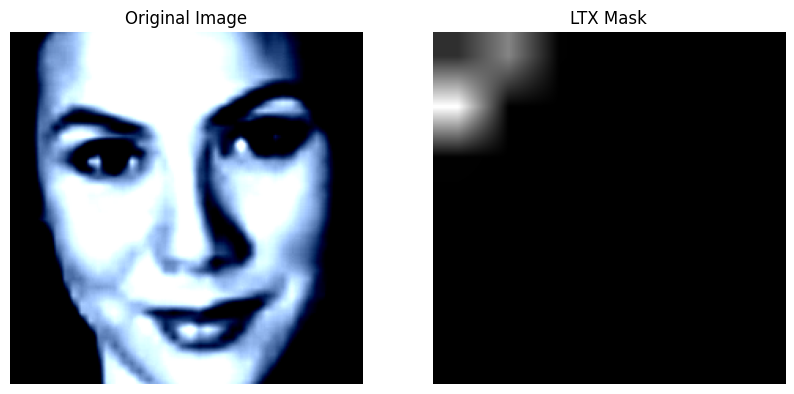

In [45]:
sample = next(iter(test_loader))
# num_images = len(sample[0])
num_images = 1  
pre_trained_ltx = LTX.load_from_checkpoint(os.path.join(checkpoints_path, "best-checkpoint.ckpt"), explained_model=explained_model, explainer=explainer)

pre_trained_ltx = pre_trained_ltx.to(device)

# run ltx on the data point
trainer = Trainer(
    max_epochs=25,
    accelerator='gpu',
    enable_checkpointing=False,
    logger=False,
)

for i in tqdm(range(num_images)):
    image = sample[0][i]
    target = sample[1][i]
    data_point = SingleTensorData(image=image, target=target)
    data_loader = DataLoader(data_point, batch_size=1)

    # trainer.fit(
    #     model=pre_trained_ltx,
    #     train_dataloaders=data_loader,
    #     val_dataloaders=data_loader,
        
    # )



# plot the original image and the mask
with torch.no_grad():
    mask, token_mask = pre_trained_ltx(image.unsqueeze(0).to(device))

plot_mask = mask.reshape(img_size, img_size)
# normalize the mask to [0, 1] for visualization
t_min = plot_mask.min()
t_max = plot_mask.max()
plot_mask = (plot_mask - t_min) / (t_max - t_min)
# expand to 3 channels for visualization
plot_mask = plot_mask.unsqueeze(-1).repeat(1, 1, 3)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(plot_mask.cpu().numpy())
plt.title("LTX Mask")
plt.axis('off')
plt.show()

In [18]:
# plot the original image and the mask
with torch.no_grad():
    mask, token_mask = ltx(image.unsqueeze(0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


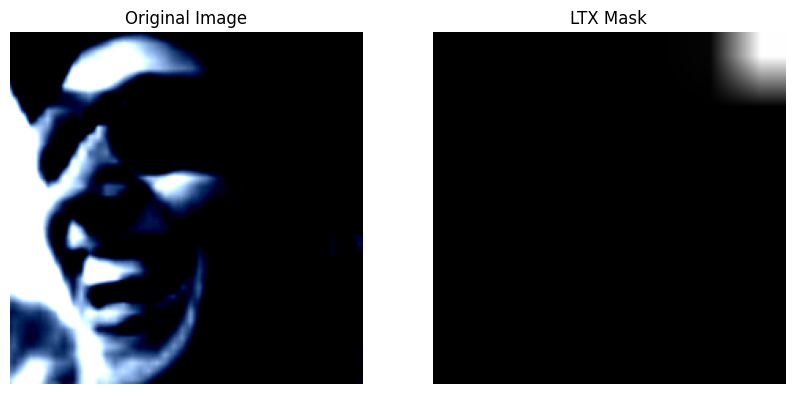

In [24]:
plot_mask = mask.reshape(img_size, img_size)
# normalize the mask to [0, 1] for visualization
t_min = plot_mask.min()
t_max = plot_mask.max()
plot_mask = (plot_mask - t_min) / (t_max - t_min)
# expand to 3 channels for visualization
plot_mask = plot_mask.unsqueeze(-1).repeat(1, 1, 3)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(plot_mask.cpu().numpy())
plt.title("LTX Mask")
plt.axis('off')
plt.show()